In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
import io
import os
import unicodedata
import re
import string
from numpy import linalg
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import webtext
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from get_tweets import get_tweets_by_search_term

In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
keywords = input("Enter keywords, hashtags separated by commas: ")
keywords = list(set(keywords.split(",")))
get_tweets_by_search_term(keywords)

,name,tweet,retweets,location,created,followers,is_user_verified
0,heavydu91443892,@DavidMMugambi @WilliamsRuto @essyokenyuri @Hu...,0,"Kenyase, Ghana",15-Mar-2022,127,False
1,reggaeholic_,Hawa politicians wako na Ruto waombe sana Rut...,0,Kenya,15-Mar-2022,3529,False
2,IIshadowboyII,@ruto_2k You're welcome. I have a problem with...,0,He/Him,15-Mar-2022,249,False
3,matesobilachuki,@Iamcayvooh @PeterNzuku Kalenjin votes and hal...,0,,15-Mar-2022,2418,False
4,Ochieng16a,@RailaOdinga @JSHeappey The other day Ruto was...,0,"Nanyuki, Kenya",15-Mar-2022,262,False
...,...,...,...,...,...,...,...
4995,Kenyans,DP Ruto and Mama Rachel on their way to the #U...,16,"Nairobi, Kenya",15-Mar-2022,526372,True
4996,komradeisaka,"For the first time in 30 years, Mount Kenya is...",2,"Nairobi, Kenya",15-Mar-2022,18751,False
4997,Channel54News,KENYA:#POLITICS\n\nDP William Ruto set to be n...,2,"NBO, info@channel54news.co.ke",15-Mar-2022,2824,False
4998,LindaNekesah,The same William Ruto who promised Kenyans one...,0,Nairobi,15-Mar-2022,329,False


In [4]:
this_file_path = os.path.abspath("__file__")
BASE_DIR = os.path.dirname(this_file_path)
tweet_pickle_file = os.path.join(BASE_DIR, "tweets", "tweet_list.pkl")
tweets_df = pd.read_pickle(tweet_pickle_file)
tweets_df.head(10)
tweet_list = tweets_df['tweet'].to_list()

In [5]:
def percentage(part, whole):
    return 100 * float(part)/float(whole)

In [6]:
positive_tweets = 0
negative_tweets = 0
neutral_tweets = 0
polarity = 0
neutral_tweets_list = []
positive_tweets_list = []
negative_tweets_list = []

for tweet in tweet_list:
    analysis =  TextBlob(tweet)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity

    if neg > pos:
        negative_tweets_list.append(tweet)
        negative_tweets += 1
    elif pos > neg:
        positive_tweets_list.append(tweet)
        positive_tweets += 1
    else:
        neutral_tweets_list.append(tweet)
        neutral_tweets += 1

positive = percentage(positive_tweets, len(tweet_list))
negative = percentage(negative_tweets, len(tweet_list))
neutral = percentage(neutral_tweets, len(tweet_list))
polarity = percentage(polarity, len(tweet_list))
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

tweet_df = pd.DataFrame(tweet_list)
neutral_tweets_df = pd.DataFrame(neutral_tweets_list)
positive_tweets_df = pd.DataFrame(positive_tweets_list)
negative_tweets_df = pd.DataFrame(negative_tweets_list)

print(f"Total tweets: {len(tweet_list)} were retrieved and analysed.")
print(f"Positive tweets: {positive_tweets} ({positive}%) included positive sentiment")
print(f"Negative tweets: {negative_tweets} ({negative}%) included negative sentiment")
print(f"Neutral tweets: {neutral_tweets} ({neutral}%) included neutral sentiment")

Total tweets: 5000 were retrieved and analysed.
Positive tweets: 2310 (46.2%) included positive sentiment
Negative tweets: 1362 (27.2%) included negative sentiment
Neutral tweets: 1328 (26.6%) included neutral sentiment


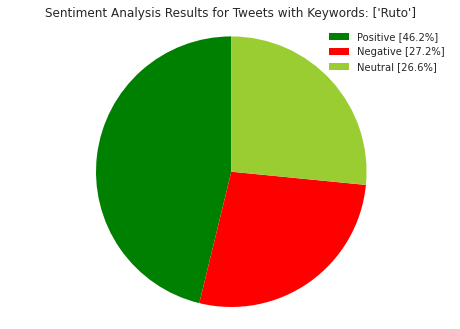

In [11]:
labels = ['Positive ['+str(positive)+'%]', 'Negative ['+str(negative)+'%]', 'Neutral ['+str(neutral)+'%]']
sizes = [positive_tweets, negative_tweets, neutral_tweets]
colors = ['green', 'red', 'yellowgreen']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.style.use('seaborn')
plt.legend(labels)
plt.title(f"Sentiment Analysis Results for Tweets with Keywords: {keywords}")
plt.axis('equal')
plt.show()

In [8]:
# Cleaning Text - Drop duplicates, RT, Punctuations, Emojis, etc
tweet_df.drop_duplicates(inplace=True)
tweet_df.dropna(inplace=True)
tweet_df_temp = pd.DataFrame(tweet_df)
tweet_df_temp['tweet'] = tweet_df_temp[0]

rt = re.compile(r'RT @[A-Za-z0-9]+:')
tweet_df_temp['tweet'] = tweet_df_temp['tweet'].str.replace(rt, '')
mention = re.compile(r'@[A-Za-z0-9]+')
tweet_df_temp['tweet'] = tweet_df_temp['tweet'].str.replace(mention, '')
url = re.compile(r'https?://[A-Za-z0-9./]+')
tweet_df_temp['tweet'] = tweet_df_temp['tweet'].str.replace(url, '')
punctuation = re.compile(r'[^\w\s]')
tweet_df_temp['tweet'] = tweet_df_temp['tweet'].str.replace(punctuation, '')
tweet_df_temp.head(10)


,0,tweet
0,@DavidMMugambi @WilliamsRuto @essyokenyuri @Hu...,I will support William Ruto because he is...
1,Hawa politicians wako na Ruto waombe sana Rut...,Hawa politicians wako na Ruto waombe sana Rut...
2,@ruto_2k You're welcome. I have a problem with...,_2k Youre welcome I have a problem with overth...
3,@Iamcayvooh @PeterNzuku Kalenjin votes and hal...,Kalenjin votes and half of Mt Kenya will not...
4,@RailaOdinga @JSHeappey The other day Ruto was...,The other day Ruto was telling Kenyans that ...
5,"What Ruto Did is a recipe for Dictatorship, Ju...",What Ruto Did is a recipe for Dictatorship Jus...
6,@PeterRatemo4 @WilliamsRuto Ruto begs Kenyans ...,Ruto begs Kenyans not to sing yote Yawezeka...
7,@BravinYuri Can uhuru first Resign for campaig...,Can uhuru first Resign for campaigning for th...
8,"For the Kiambu aspirants Governor race, who wi...",For the Kiambu aspirants Governor race who wil...
9,@makaumutua You guys talk about Ruto more than...,You guys talk about Ruto more than your candi...


In [9]:
# Calculate the sentiment of each cleaned tweet
tweet_df_temp[['polarity', 'subjectivity']] = tweet_df_temp['tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tweet_df_temp['tweet'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tweet_df_temp.loc['sentiment'] = 'negative'
    elif pos > neg:
        tweet_df_temp.loc['sentiment'] =  'positive'
    else:
        tweet_df_temp['sentiment'] =  'neutral'
    tweet_df_temp.loc['neg'] = neg
    tweet_df_temp.loc['neu'] = neu
    tweet_df_temp.loc['pos'] = pos
    tweet_df_temp.loc['compound'] = comp
tweet_df_temp.head(10)



,0,tweet,polarity,subjectivity,sentiment
0,@DavidMMugambi @WilliamsRuto @essyokenyuri @Hu...,I will support William Ruto because he is...,0.28,0.293333,neutral
1,Hawa politicians wako na Ruto waombe sana Rut...,Hawa politicians wako na Ruto waombe sana Rut...,0.8,0.4,neutral
2,@ruto_2k You're welcome. I have a problem with...,_2k Youre welcome I have a problem with overth...,0.333333,0.566667,neutral
3,@Iamcayvooh @PeterNzuku Kalenjin votes and hal...,Kalenjin votes and half of Mt Kenya will not...,-0.041667,0.572917,neutral
4,@RailaOdinga @JSHeappey The other day Ruto was...,The other day Ruto was telling Kenyans that ...,0.291667,0.491667,neutral
5,"What Ruto Did is a recipe for Dictatorship, Ju...",What Ruto Did is a recipe for Dictatorship Jus...,0.1,0.216667,neutral
6,@PeterRatemo4 @WilliamsRuto Ruto begs Kenyans ...,Ruto begs Kenyans not to sing yote Yawezeka...,0.0,0.0,neutral
7,@BravinYuri Can uhuru first Resign for campaig...,Can uhuru first Resign for campaigning for th...,-0.125,0.666667,neutral
8,"For the Kiambu aspirants Governor race, who wi...",For the Kiambu aspirants Governor race who wil...,0.0,0.066667,neutral
9,@makaumutua You guys talk about Ruto more than...,You guys talk about Ruto more than your candi...,0.4125,0.75,neutral
